# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud
import geopandas
import itertools
import matplotlib as mpl
from zipfile import ZipFile
pd.options.display.max_columns = 100
plt.style.use(['default'])

# Constants

In [3]:
themes = [
    'Authorities & Politics', 'Cases and deaths', 'Economic impact', 'Educational impact', 'People stories',
       'Preventive measures', 'Vaccines and vaccination', 'Virus spreading'
]

subthemes = [
    'subtheme11', 'subtheme12', 'subtheme21', 'subtheme22', 'subtheme41', 'subtheme42', 'subtheme43', 
    'subtheme44', 'subtheme51', 'subtheme52', 'subtheme53', 'subtheme61', 'subtheme62', 'subtheme63', 
    'subtheme64', 'subtheme65', 'subtheme66', 'subtheme71', 'subtheme72', 'subtheme73', 'subtheme74'
]

emotions = [
    'anger', 'sadness', 'optimism', 'joy'
]

keywords = [
    'remote working', 'homeschooling', 'panic buying', 'sars-cov-2', 'wearing masks', 'ncov', 'wuhan', 
    'social distancing', 'vaccination', 'quarantine', 'outbreak', 'vaccine', 'lockdown', 'pandemic', 
    'coronavirus', 'covid'
]
keywords2 = [w.replace(' ', '_').replace('-', '_') for w in keywords]

# Functions

In [4]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.fm' % (x * 1e-3)

# Load and process lookup tables

In [5]:
# Load lookup tables
media_list = pd.read_csv('./../data/external/MediaList.csv', sep=";")
theme_desc = pd.read_csv('./../data/external/theme_desc.csv')
subtheme_desc = pd.read_csv('./../data/external/subtheme_desc.csv')
topics = pd.read_parquet('./../data/processed/news_tweets_topics_0612.parquet')
news_accounts = pd.concat([
    pd.read_parquet('./../data/raw/news_accounts.parquet'), 
    pd.read_parquet('./../data/processed/skynews/news_accounts_skynews.parquet')
])

# Process lookup tables
topics['tweetId'] = topics.tweetId.astype('float64')
news_accounts = news_accounts.merge(media_list)
news_accounts['userId'] = news_accounts.userId.astype('float64')

# Load and process News Tweets and Comments (only run once)

In [6]:
# # Load news tweets
# news_tweets = pd.concat([
#     pd.read_parquet('./../data/raw/news_tweets.parquet'), 
#     pd.read_parquet('./../data/processed/skynews/news_tweets_skynews.parquet')
# ])

# # Include country information and filter valid news accountsw
# news_tweets = news_tweets.merge(news_accounts[['userId','country']])
# news_tweets = news_tweets[news_tweets.lang=='en']
# news_tweets['tweetId'] = news_tweets.tweetId.astype('float64')

# # Include emotions
# old_news_with_em = pd.read_parquet('./../data/raw/news_tweets_with_em_scores.parquet')
# skynews_with_em = pd.read_csv('./../data/processed/skynews/em_scores/news_tweets_with_em_scores.csv')
# skynews_with_em['tweetId'] = skynews_with_em.tweetId.astype('float64')
# tweet_emotion_scores = pd.concat([
#     old_news_with_em.loc[~old_news_with_em.tweetId.isnull(), ['tweetId'] + emotions],
#     skynews_with_em[['tweetId'] + emotions]
# ]).reset_index(drop=True)
# news_tweets = news_tweets.merge(tweet_emotion_scores)
# news_tweets = news_tweets.sort_values('date').drop_duplicates('conversationId', keep='first')
# news_tweets = news_tweets[~news_tweets[emotions].isnull().any(axis=1)]

# # Define prevalent emotion and emotion score
# news_tweets['emotion_score'] = news_tweets[['anger','joy','optimism','sadness']].max(axis=1)
# news_tweets['prevalent_emotion'] = news_tweets[['anger','joy','optimism','sadness']].idxmax(axis=1)
# news_tweets['prevalent_emotion'] = np.where(news_tweets.emotion_score>0.5, news_tweets.prevalent_emotion, 'undefined')

# # Include theme and subtheme
# news_tweets = news_tweets[~news_tweets.conversationId.isnull()].merge(topics[['theme'] + subthemes + ['tweetId']], how='left', on='tweetId')
# news_tweets = news_tweets[~news_tweets[subthemes].isnull().any(axis=1)]
# news_tweets['subtheme'] = news_tweets[subthemes].astype(int).idxmax(axis=1)
# news_tweets['subtheme'] = news_tweets.subtheme.apply(lambda x: int(x[-2:]))
# news_tweets['aux'] = news_tweets[subthemes].sum(axis=1)
# news_tweets.loc[news_tweets.aux==0,'subtheme'] = news_tweets.loc[news_tweets.aux==0,'theme']*10
# news_tweets = news_tweets.drop(subthemes + ['aux'], axis=1)

# # Include date and week features
# news_tweets['ds'] = news_tweets.date.dt.date
# news_tweets['dsw'] = (news_tweets['date'] + pd.offsets.Week(weekday=6)).dt.date
# print('Number of valid news tweets:', news_tweets.shape[0])

# #
# news_tweets.to_parquet('consolidated_news_tweets.parquet', index=False, compression='gzip')

In [7]:
# # Load comments
# comments = pd.concat([
#     pd.read_parquet('./../data/raw/comments.parquet'), 
#     pd.read_parquet('./../data/processed/skynews/comments_skynews.parquet')
# ])
# comments = comments[comments.lang=='en']
# comments['tweetId'] = comments.tweetId.astype('float64')
# comments.shape

# # Include emotions
# old_replies_with_em = pd.read_parquet('./../data/raw/user_tweets_with_em_scores.parquet')
# old_replies_with_em = old_replies_with_em.loc[~old_replies_with_em.tweetId.isnull(), ['tweetId'] + emotions]
# skynews_replies_with_em = pd.read_csv('./../data/processed/skynews/em_scores/user_replies_with_em_scores.csv')
# skynews_replies_with_em['tweetId'] = skynews_replies_with_em.tweetId.astype('float64')
# tweet_emotion_scores = pd.concat([old_replies_with_em,skynews_replies_with_em])
# comments = comments.merge(tweet_emotion_scores).reset_index(drop=True)
# comments['date'] = pd.to_datetime(comments.date, utc=True)
# comments = comments.sort_values('date').drop_duplicates('tweetId', keep='first')
# comments = comments[~comments[emotions].isnull().any(axis=1)]

# # Include news tweet data
# comments = comments.merge(news_tweets.rename(columns={
#     'date':'news_date', 'userId':'news_id', 'prevalent_emotion':'news_prevalent_emotion', 'emotion_score':'news_emotion_score',
#     'anger':'news_anger', 'sadness':'news_sadness', 'optimism':'news_optimism', 'joy':'news_joy'
# })[[
#     'conversationId', 'news_date', 'news_id', 'news_prevalent_emotion', 'news_emotion_score', 
#     'news_anger', 'news_sadness', 'news_optimism', 'news_joy', 'theme', 'subtheme', 'country'
# ]], how='left')

# # Define prevalent emotion and emotion score
# comments['emotion_score'] = comments[['anger','joy','optimism','sadness']].max(axis=1)
# comments['prevalent_emotion'] = comments[['anger','joy','optimism','sadness']].idxmax(axis=1)
# comments['prevalent_emotion'] = np.where(comments.emotion_score>0.5, comments.prevalent_emotion, 'undefined')

# # Define continent information
# comments = comments.merge(pd.DataFrame({
#     'country':['AU', 'UK', 'US', 'CA', 'NZ', 'ZA', 'KE', 'NG', 'IN', 'PH', 'MY','IE'],
#     'continent':['Oceania', 'Europe', 'America', 'America', 'Oceania', 'Africa', 'Africa', 'Africa', 'Asia', 'Asia', 'Asia', 'Europe']
# }))

# # Include date, week and month features
# comments['ds'] = comments.news_date.dt.date
# comments['dsw'] = (comments['news_date'] + pd.offsets.Week(weekday=6)).dt.date
# comments['dsm'] = pd.to_datetime(comments.news_date.dt.year.astype(str) + '-' + comments.news_date.dt.month.astype(str) + '-1')
# print('Number of valid user replies:', comments.shape[0])
# print('Number of valid user in replies:', comments.userId.nunique())

# #
# comments.to_parquet('consolidated_user_replies.parquet', index=False, compression='gzip')

In [8]:
# # Save news and comments in zip files (without the content)
# out_cols = [
#     'tweetId', 'conversationId', 'userId', 'date', 'sourceLabel', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
#     'longitude', 'latitude', 'place', 'anger', 'sadness', 'optimism', 'joy'
# ]

# news_tweets['month_year'] = news_tweets.ds.apply(lambda x: str(x)[:7])
# comments['month_year'] = comments.news_date.apply(lambda x: str(x)[:7])

# for month_year in comments.month_year.unique():
#     filename = "./../data/processed/outdata/news_tweets_" + month_year
#     news_tweets[news_tweets.month_year==month_year][out_cols].to_csv(filename + ".csv", index=False)
#     make_tarfile(filename + ".tar", filename + ".csv")
    
#     filename = "./../data/processed/outdata/user_replies_" + month_year
#     comments[comments.month_year==month_year][out_cols].to_csv(filename + ".csv", index=False)
#     make_tarfile(filename + ".tar", filename + ".csv")

# Load consolidated news tweets and comments

In [9]:
news_tweets = pd.read_parquet('consolidated_news_tweets.parquet')
news_tweets.shape

(1705830, 25)

In [10]:
comments = pd.read_parquet('consolidated_user_replies.parquet')
comments.shape

(18601330, 35)

# Paper Figures

### Fig 1

In [11]:
def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = mpl.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = mpl.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = mpl.colors.ListedColormap(cols)
    return cmap

# Define less frequent keywords
less_freq_kw = ['vaccination', 'quarantine', 'remote_working', 'homeschooling', 'panic_buying', 'sars_cov_2', 'wearing_masks', 'ncov', 'wuhan', 'social_distancing']

# Define subplots dataframes
fig1_kw = news_tweets.copy()
for i, w in enumerate(keywords):
    fig1_kw[keywords2[i]] = fig1_kw.content.apply(lambda x: w in x.lower())
fig1_kw[keywords2].sum().sort_values().index
fig1_kw = fig1_kw.groupby('dsw')[keywords2].sum()
fig1_kw['other'] = fig1_kw[less_freq_kw].sum(axis=1)
fig1_kw = fig1_kw[[
    'covid', 'coronavirus', 'pandemic', 'lockdown', 'vaccine', 'outbreak', 'other'
]]
fig1_nt = news_tweets.groupby('dsw')[emotions].mean()
fig1_cm = comments.groupby('dsw')[['anger', 'sadness', 'optimism', 'joy']].mean()

# Define colormaps
c1 = categorical_cmap(3, 10, cmap="tab10")
c2 = categorical_cmap(1, 4, cmap="tab10")

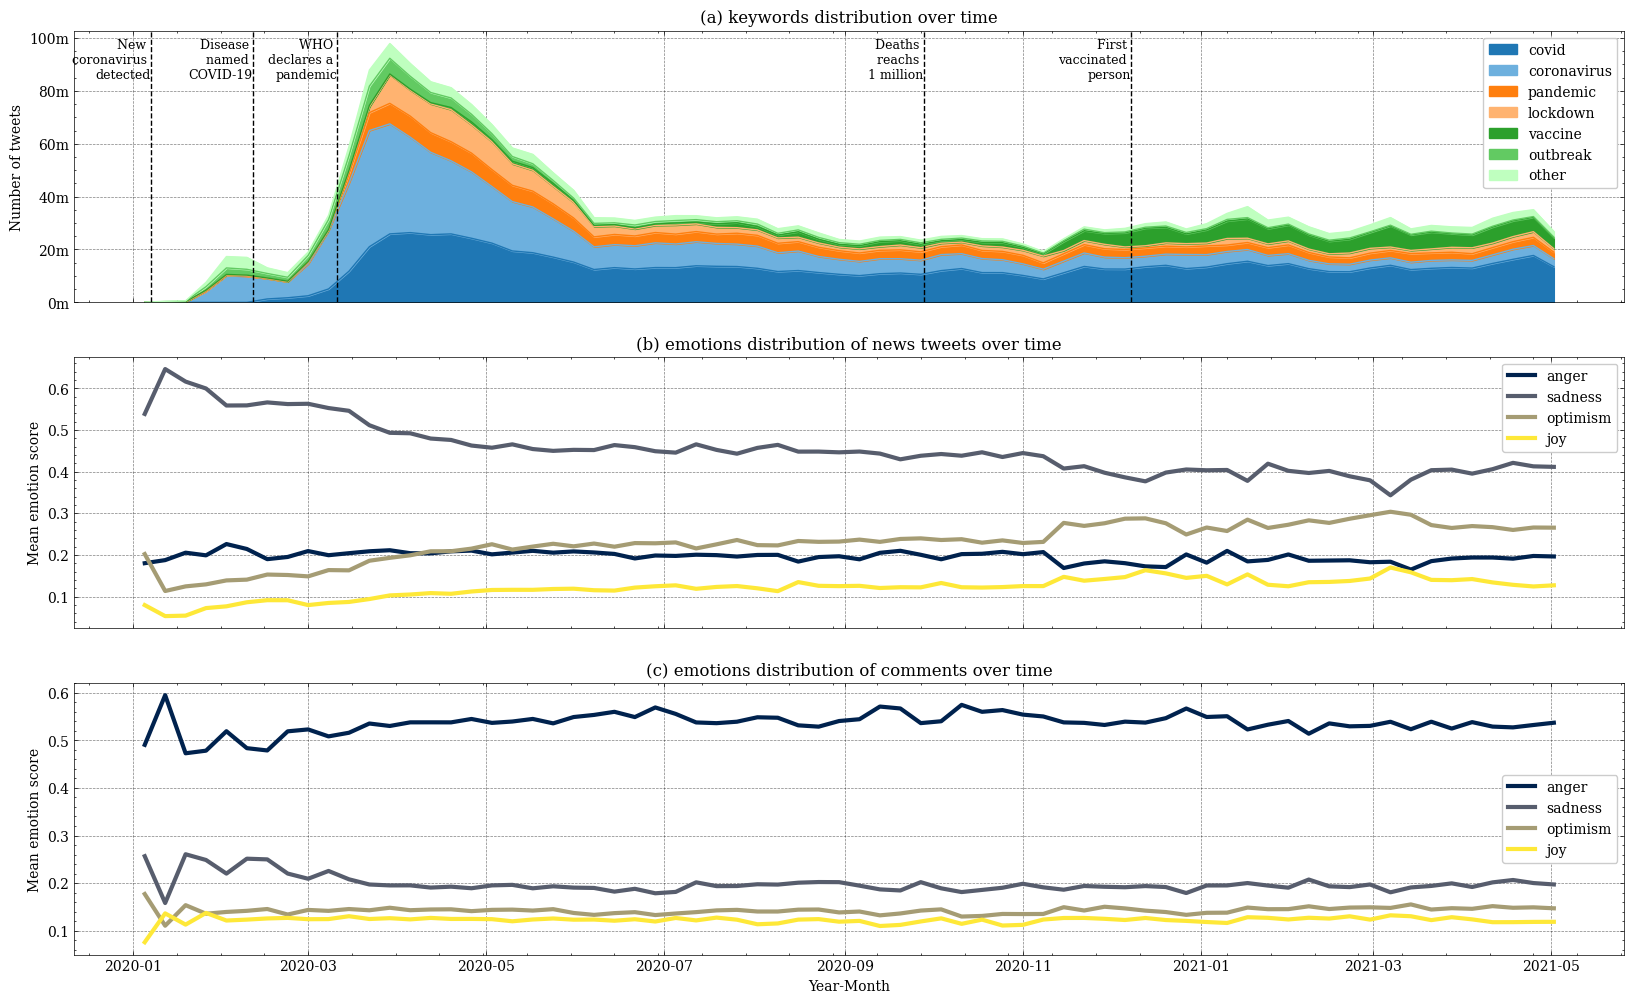

In [12]:
# Plot figure
with plt.style.context(['science', 'no-latex', 'grid']):
    formatter = FuncFormatter(thousands)
    fig, axs = plt.subplots(3,1,figsize=(20, 12), sharex=True)
    fig1_kw.plot.area(ax=axs[0], title="(a) keywords distribution over time", ylabel="Number of tweets", cmap=c1); axs[0].yaxis.set_major_formatter(formatter)
    
    # Add labels to the plot
    style = dict(size=9, color='black')
    
    axs[0].axvline(pd.Timestamp('2020-01-07'),color='k',linestyle='--')
    axs[0].text('2020-01-07', 100000, "New \ncoronavirus \ndetected", ha='right', va='top', **style)

    axs[0].axvline(pd.Timestamp('2020-02-11'),color='k',linestyle='--')
    axs[0].text('2020-2-11', 100000, "Disease \nnamed \nCOVID-19", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-03-11'),color='k',linestyle='--')
    axs[0].text('2020-3-11', 100000, "WHO \ndeclares a \npandemic", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-09-28'),color='k',linestyle='--')
    axs[0].text('2020-09-28', 100000, "Deaths \nreachs \n1 million", ha='right', va='top', **style)
    
    axs[0].axvline(pd.Timestamp('2020-12-08'),color='k',linestyle='--')
    axs[0].text('2020-12-08', 100000, "First \nvaccinated \nperson", ha='right', va='top', **style)
    
    fig1_nt.plot.line(ax=axs[1], title="(b) emotions distribution of news tweets over time", ylabel="Mean emotion score", linewidth=3, cmap='cividis')
    fig1_cm.plot.line(ax=axs[2], title="(c) emotions distribution of comments over time", ylabel="Mean emotion score", xlabel="Year-Month", linewidth=3, cmap='cividis')

### Fig 2

In [13]:
cd = {
    'AU':'Australia', 'UK':'UK', 'IN':'India', 'NZ':'New Zealand', 
    'NG':'Nigeria', 'IE':'Ireland', 'CA':'Canada', 'KE':'Kenya', 
    'ZA':'South Africa', 'PH':'Philippines', 'US':'USA', 'MY':'Malaysia'
}

In [14]:
fig2_th = news_tweets.merge(theme_desc).groupby(['country', 'theme_desc']).tweetId.nunique().rename('tweet_count').reset_index()
fig2_th = fig2_th.pivot_table('tweet_count', ['country'], 'theme_desc')
fig2_th['sum'] = fig2_th.sum(axis=1)
fig2_th.iloc[:, :-1] = fig2_th.iloc[:, :-1].div(fig2_th['sum'], axis=0)
fig2_th = fig2_th.drop('sum', axis=1).reset_index()
fig2_th = fig2_th[['country'] + list(fig2_th[themes].sum().sort_values(ascending=False).index)]
fig2_th = fig2_th.sort_values('Preventive measures', ascending=True)

fig2_em = comments.groupby(['country', 'prevalent_emotion']).tweetId.nunique().rename('tweet_count').reset_index()
fig2_em = fig2_em.pivot_table('tweet_count', ['country'], 'prevalent_emotion')
fig2_em['sum'] = fig2_em.sum(axis=1)
fig2_em.iloc[:, :-1] = fig2_em.iloc[:, :-1].div(fig2_em['sum'], axis=0)
fig2_em = fig2_em.drop('sum', axis=1).reset_index()
fig2_em = fig2_em[['country'] + list(fig2_em[emotions + ['undefined']].sum().index)]
fig2_em = fig2_em.sort_values('anger')

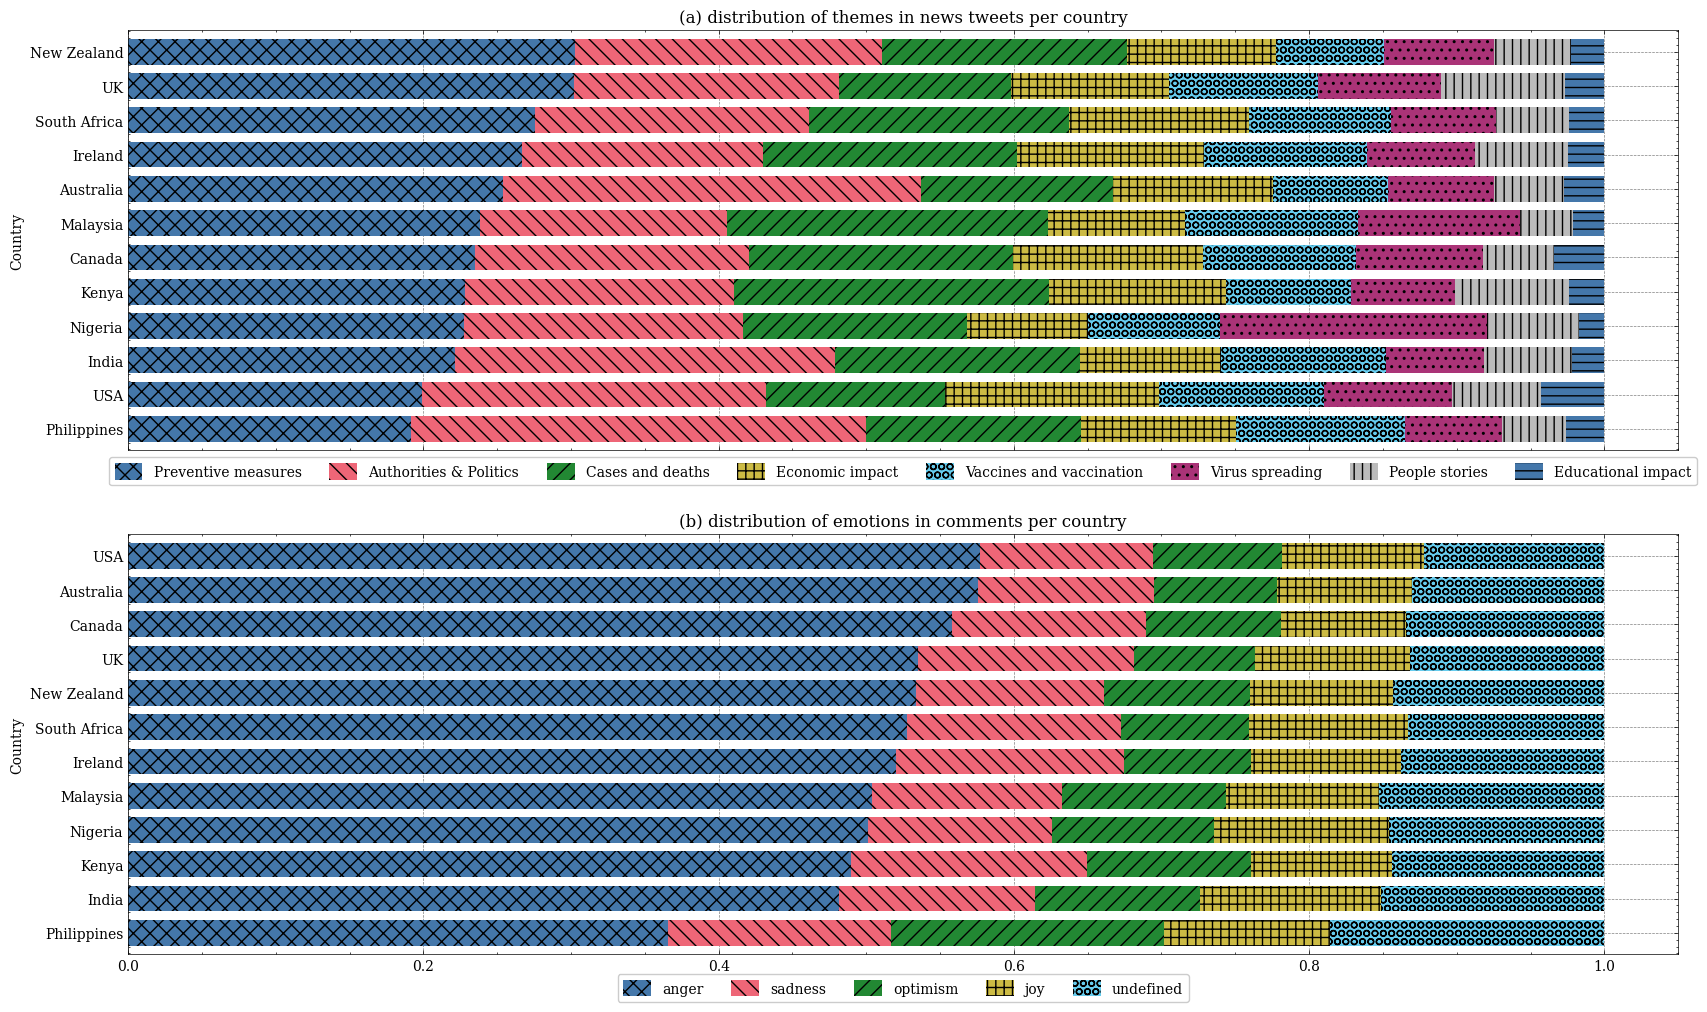

In [15]:
# plot a Stacked Bar Chart using matplotlib
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    
    patterns = ['xx', '\\\\', '//', '++', 'OO', '..', '||', '--']
    fig, axs = plt.subplots(2,1,figsize=(20, 12), sharex=True)

    fig2_th['country'] = fig2_th.country.replace(cd)
    fig2_th.plot(
        ax=axs[0],
        title="(a) distribution of themes in news tweets per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        width=0.75,
        stacked = True,
        mark_right = True)
    bars = [thing for thing in axs[0].containers if isinstance(thing,mpl.container.BarContainer)]
    for k,bar in enumerate(bars):
        for patch in bar:
            patch.set_hatch(patterns[k])
    L = axs[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=8, handleheight=1.5)
    axs[0].set_yticklabels(fig2_th.country.values)

    fig2_em['country'] = fig2_em.country.replace(cd)
    fig2_em.plot(
        ax=axs[1],
        title="(b) distribution of emotions in comments per country",
        xlabel = 'Country',
        x = 'country',
        kind = 'barh',
        width=0.75,
        stacked = True,
        mark_right = True)
    bars = [thing for thing in axs[1].containers if isinstance(thing,mpl.container.BarContainer)]
    for k,bar in enumerate(bars):
        for patch in bar:
            patch.set_hatch(patterns[k])
    L = axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.13),ncol=8, handleheight=1.5)
    axs[1].set_yticklabels(fig2_em.country.values)

### Fig 3
- Each month's lift represents how that continent performed in relation to global mean of that emotion in that specific month.

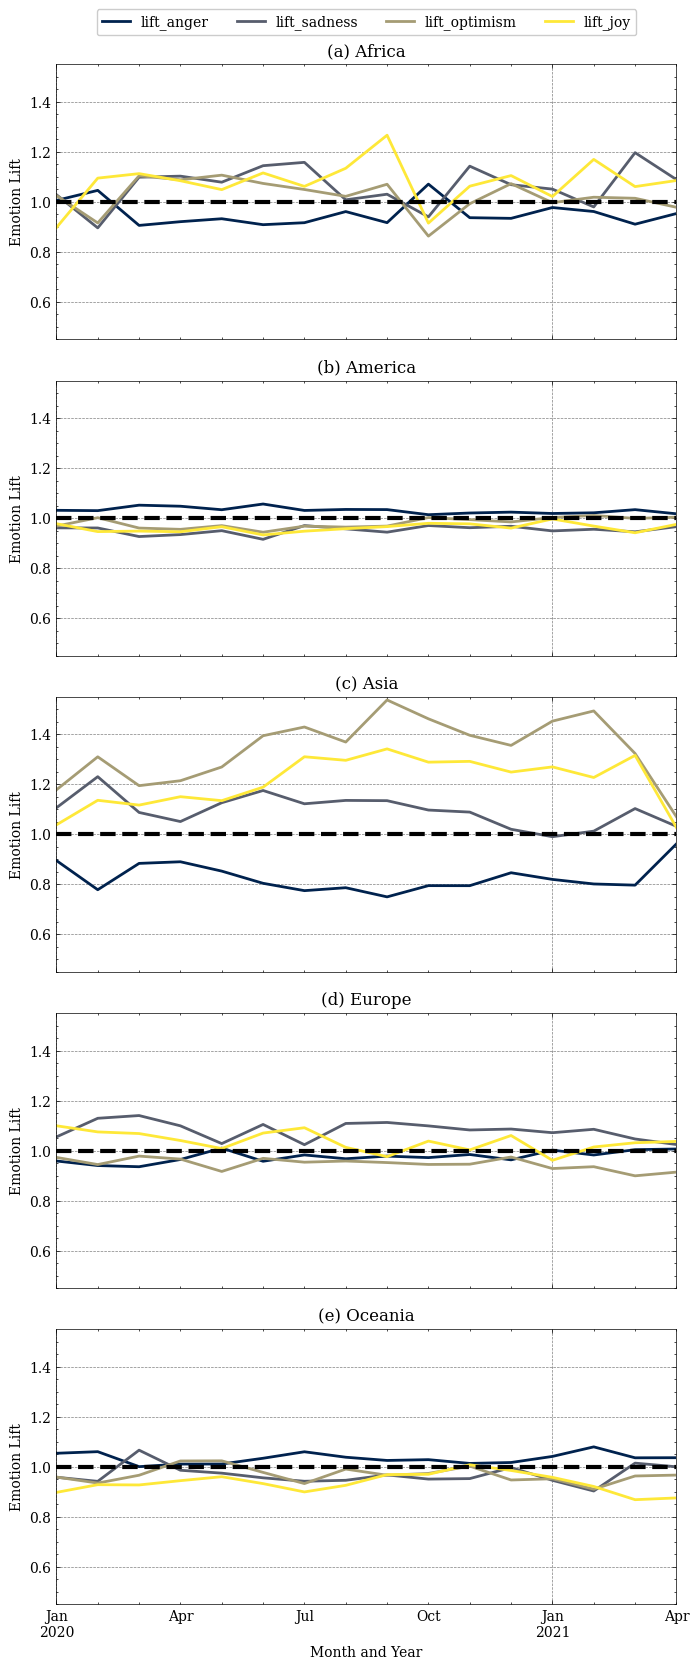

In [16]:
fig3_gn = comments.groupby('dsm')[emotions].mean().reset_index()
fig3_lf = comments.groupby(['continent', 'dsm']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
fig3_lf = fig3_lf.merge(fig3_gn, on='dsm', suffixes=('_continent', '_general'))

for col in emotions:
    fig3_lf['lift_' + col] = fig3_lf[col + '_continent'] / fig3_lf[col + '_general']

with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    gen_ylim = (.45,1.55)
    fig, axs = plt.subplots(5,1,figsize=(8, 20), sharex='all')
    plt.subplots_adjust(hspace=0.15)
    fig3_lf[fig3_lf.continent=='Africa'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[0], ylim=gen_ylim, title='(a) Africa', linewidth=2, ylabel = "Emotion Lift", cmap='cividis').legend(loc='lower center', bbox_to_anchor=(0.5, 1.08),ncol=4)
    axs[0].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='America'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[1], ylim=gen_ylim, title='(b) America', legend=False, linewidth=2, ylabel = "Emotion Lift", cmap='cividis')
    axs[1].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Asia'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[2], ylim=gen_ylim, title='(c) Asia', legend=False, linewidth=2, ylabel = "Emotion Lift", cmap='cividis')
    axs[2].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Europe'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[3], ylim=gen_ylim, title='(d) Europe', legend=False, linewidth=2, ylabel = "Emotion Lift", cmap='cividis')
    axs[3].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)
    fig3_lf[fig3_lf.continent=='Oceania'].set_index('dsm')[['lift_anger', 'lift_sadness', 'lift_optimism', 'lift_joy']].plot(ax=axs[4], ylim=gen_ylim, title='(e) Oceania', legend=False, linewidth=2, ylabel = "Emotion Lift", xlabel='Month and Year', cmap='cividis')
    axs[4].axhline(1, xmin=0, xmax=1, color='k', linestyle='--', lw=3)

### Fig 4

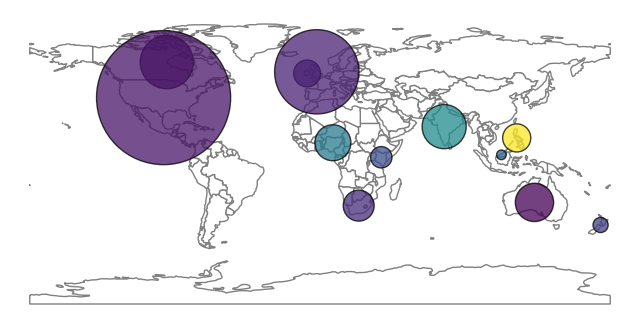

In [17]:
comments['positive'] = comments.joy + comments.optimism
comments['negative'] = comments.anger + comments.sadness
fig4_cn = comments.groupby(['country']) \
       .agg({'positive':'mean', 'negative':'mean', 'tweetId':'count'}) \
       .reset_index()
fig4_cn['mean_emotion'] = (fig4_cn.positive - fig4_cn.negative)
fig4_lc = pd.read_csv('./../data/external/countries_codes_and_coordinates.txt')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

for col in fig4_lc.columns:
    fig4_lc[col] = fig4_lc[col].apply(lambda x: x.replace('"', ''))
fig4_lc = fig4_lc[['Alpha-2 code', 'Latitude (average)', 'Longitude (average)']]
fig4_lc.columns = ['country', 'lat', 'lng']
fig4_lc['lat'] = fig4_lc.lat.astype(float)
fig4_lc['lng'] = fig4_lc.lng.astype(float)

fig4_lc = geopandas.GeoDataFrame(
    fig4_lc, geometry=geopandas.points_from_xy(fig4_lc.lng, fig4_lc.lat))
fig4_lc['country'] = fig4_lc.country.apply(lambda x: x.replace(' ',''))
fig4_lc.loc[fig4_lc.country=='GB', 'country'] = 'UK'
fig4_lc = fig4_lc.merge(fig4_cn)
fig4_lc['tweetId'] = fig4_lc.tweetId / 1000

tweet_count = fig4_lc.tweetId.values
mean_emotion = fig4_lc.mean_emotion.values

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_aspect('equal')
base = world.plot(ax=ax, color='white', edgecolor='gray')
fig4_lc.plot(ax=ax, marker='o', c=mean_emotion, markersize="tweetId", alpha=0.75, edgecolors="black", linewidth=1, categorical=False)

ax.axis("off")
plt.axis('equal')
plt.show()

### Fig 5

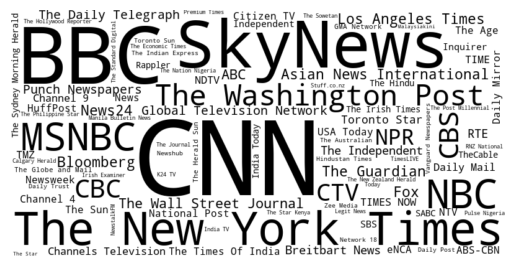

In [18]:
#n = news_tweets.groupby('userId').replyCount.count().reset_index().merge(news_accounts[['userId', 'media_outlet']])[['media_outlet', 'replyCount']]
n = comments.groupby('news_id').tweetId.count().reset_index().merge(news_accounts[['userId', 'media_outlet']], left_on='news_id', right_on='userId')[['media_outlet', 'tweetId']].groupby('media_outlet').tweetId.sum().reset_index()
n = n.replace('ABC (American Broadcasting Company)', 'ABC')
n = n.replace('ABC (Australian Broadcasting Corporation)', 'ABC')
d = {}
for index, row in n.iterrows():
    d[row.media_outlet] = int(row.tweetId)
wordcloud = WordCloud(
    relative_scaling=.5, background_color='white', color_func=lambda *args, **kwargs: (0,0,0), random_state=13, min_font_size=8, width=800, height=400
).generate_from_frequencies(d)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Fig 6

In [19]:
topics = [2,5,8,11,14,17,20,23,26,29,32,35,38]
coherence = [0.1904751007100423,
 0.37879459862606674,
 0.42374450561744703,
 0.4644860060338329,
 0.487347851713527,
 0.4946509603327943,
 0.5126522710767392,
 0.5197612616471091,
 0.5102378284271195,
 0.5372328881105903,
 0.5216428422006523,
 0.5294609204296856,
 0.5281553643090436]

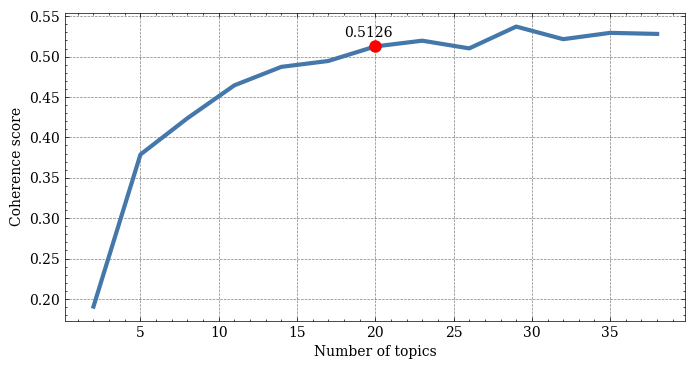

In [20]:
with plt.style.context(['science', 'bright', 'no-latex', 'grid']):
    fig, axs = plt.subplots(figsize=(8, 4))
    axs.set_ylabel('Coherence score')
    axs.set_xlabel('Number of topics')    
    axs.annotate('0.5126', xy=(18., .525))
    
    plt.plot(topics, coherence, linewidth=3, )
    plt.plot(20, 0.5126, 'ro', markersize=8, )

# Tables

### Table 3 (tab:example_news_tweets)

In [21]:
news_tweets.sample(25, random_state=99).merge(news_accounts, on=('userId','country')).iloc[[4,2,8,9]]

,tweetId,conversationId,userId,date,content,lang,sourceLabel,replyCount,retweetCount,likeCount,quoteCount,longitude,latitude,place,country,anger,sadness,optimism,joy,emotion_score,prevalent_emotion,theme,subtheme,ds,dsw,username,displayname,description,rawDescription,verified,created,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount,location,protected,linkUrl,linkTcourl,profileImageUrl,profileBannerUrl,media_outlet,media_category
4,1.257053e+18,1257052690674094080,16213124,2020-05-03 21:01:31+00:00,How to hold a kid's birthday party while socia...,en,Microsoft Power Platform,0,0,1,0,NaN,NaN,None,AU,0.092,0.768,0.046,0.094,0.768,sadness,6.0,64.0,2020-05-03,2020-05-10,abcbrisbane,ABC Brisbane,"ABC Brisbane is your place for local news, con...","ABC Brisbane is your place for local news, con...",True,2008-09-09 23:19:47+00:00,287264,36755,152514,7433,1442,15827,"Brisbane, Australia",False,https://linktr.ee/abcbrisbane,https://t.co/WBjAVpnY0m,https://pbs.twimg.com/profile_images/875608475...,https://pbs.twimg.com/profile_banners/16213124...,ABC (Australian Broadcasting Corporation),Television
2,1.333973e+18,1333973089823064064,284920800,2020-12-02 03:15:43+00:00,"Covid-19 vaccines are fast approaching, but a ...",en,TweetDeck,1,1,7,0,NaN,NaN,None,IN,0.290,0.581,0.112,0.017,0.581,sadness,8.0,80.0,2020-12-02,2020-12-06,news18dotcom,News18.com,"More than just news, analysis & opinion. The d...","More than just news, analysis & opinion. The d...",True,2011-04-20 06:14:32+00:00,152660,160,206478,58,837,14207,India,False,https://www.news18.com,https://t.co/0HnxPgwuLD,https://pbs.twimg.com/profile_images/116227427...,https://pbs.twimg.com/profile_banners/28492080...,Network 18,Television
8,1.314180e+18,1314179909481267200,138749160,2020-10-08 12:24:41+00:00,BREAKING: Covid-infected Donald Trump instantl...,en,SocialFlow,5,3,3,4,NaN,NaN,None,UK,0.894,0.083,0.014,0.009,0.894,anger,5.0,52.0,2020-10-08,2020-10-11,MetroUK,Metro,We give the people what they want 🎁,We give the people what they want 🎁,True,2010-04-30 13:32:36+00:00,334861,2621,329542,2073,3675,45527,,False,http://metro.co.uk,http://t.co/fyGOVInvbb,https://pbs.twimg.com/profile_images/132718924...,https://pbs.twimg.com/profile_banners/13874916...,Daily Mail,Newspaper
9,1.278491e+18,1278491126605975552,16715398,2020-07-02 00:50:12+00:00,Coronavirus News: Which masks protect those ar...,en,True Anthem,4,5,26,0,NaN,NaN,None,US,0.063,0.321,0.517,0.099,0.517,optimism,7.0,72.0,2020-07-02,2020-07-05,ABC7NY,Eyewitness News,"New York's #1 news, Channel 7 Eyewitness News....","New York's #1 news, Channel 7 Eyewitness News....",True,2008-10-13 02:33:46+00:00,706839,29918,343477,7833,3880,166268,New York City,False,http://abc7ny.com,https://t.co/jfhEMrUXM9,https://pbs.twimg.com/profile_images/910523413...,https://pbs.twimg.com/profile_banners/16715398...,ABC (American Broadcasting Company),Television


### Table 4 (tab:example_comments)

In [22]:
comments.iloc[[1443670,7017708,13200160,12832209]]

,tweetId,conversationId,userId,date,content,lang,sourceLabel,replyCount,retweetCount,likeCount,quoteCount,longitude,latitude,place,anger,sadness,optimism,joy,news_date,news_id,news_prevalent_emotion,news_emotion_score,news_anger,news_sadness,news_optimism,news_joy,theme,subtheme,country,emotion_score,prevalent_emotion,continent,ds,dsw,dsm,positive,negative
1443670,1.245032e+18,1244852703265722368,25948015,2020-03-31 16:57:02+00:00,@MSNBC #Stoptrumpairtime is not worth it. He ...,en,Twitter for iPhone,0,0,0,0,NaN,NaN,None,0.937,0.022,0.036,0.005,2020-03-31 05:03:07+00:00,2836421.0,optimism,0.555,0.143,0.202,0.555,0.099,8.0,80.0,US,0.937,anger,America,2020-03-31,2020-04-05,2020-03-01,0.041,0.959
7017708,1.329130e+18,1329121464650436617,1238412868544073730,2020-11-18 18:30:07+00:00,@jamft @ABC And so many doctors in Europe who ...,en,Twitter for Android,0,0,0,0,NaN,NaN,None,0.080,0.899,0.014,0.007,2020-11-18 17:57:05+00:00,28785486.0,anger,0.916,0.916,0.050,0.027,0.006,6.0,61.0,US,0.899,sadness,America,2020-11-18,2020-11-22,2020-11-01,0.021,0.979
13200160,1.325876e+18,1325858225577730050,411010755,2020-11-09 19:00:05+00:00,@samh1743 @BBCNews That wasn't a very coherent...,en,Twitter Web App,1,0,0,0,NaN,NaN,None,0.053,0.279,0.556,0.112,2020-11-09 17:50:08+00:00,612473.0,anger,0.569,0.569,0.263,0.155,0.012,7.0,70.0,UK,0.556,optimism,Europe,2020-11-09,2020-11-15,2020-11-01,0.668,0.332
12832209,1.309229e+18,1309206339730669571,826240376096845826,2020-09-24 20:32:03+00:00,@mattsole @Telegraph I heard this as well via ...,en,Twitter Web App,0,0,4,0,NaN,NaN,None,0.032,0.065,0.321,0.581,2020-09-24 19:01:29+00:00,16343974.0,optimism,0.754,0.029,0.084,0.754,0.133,7.0,72.0,UK,0.581,joy,Europe,2020-09-24,2020-09-27,2020-09-01,0.902,0.097


### Table 5 (tab:account_emotions)

In [23]:
g = comments[emotions].mean()

accounts_emotions = comments.groupby(['continent', 'country', 'news_id']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()

for col in ['anger', 'sadness', 'optimism', 'joy']:
    accounts_emotions['lift_' + col] = accounts_emotions[col] / g[col]

accounts_emotions[['lift_'+col for col in emotions]].max()

engaged_news = news_tweets.groupby('userId').tweetId.count()
engaged_news = list(engaged_news[engaged_news > 484].index)

accounts_emotions = accounts_emotions[
    (accounts_emotions.news_id.isin(engaged_news)) & (accounts_emotions.tweetId > 484)
].merge(news_accounts.drop('country',axis=1), left_on='news_id', right_on='userId', how='left')

top_news = pd.DataFrame(columns=accounts_emotions.columns)
for emotion in emotions:
    tmp = accounts_emotions[~accounts_emotions.news_id.isin(top_news.news_id.values)].sort_values(emotion).tail(5)
    tmp['main_emotion'] = emotion
    tmp['rank_emotion'] = range(1,6)
    tmp['score_emotion'] = tmp[emotion].values
    top_news = pd.concat([top_news, tmp])

account_emotions_themes = news_tweets[
    news_tweets.userId.isin(top_news.userId.values)
].groupby('userId').theme.value_counts(normalize=True).rename('prop').reset_index().merge(theme_desc)

account_emotions_themes = account_emotions_themes.pivot('userId', 'theme_desc', 'prop').reset_index()

account_emotions_themes = account_emotions_themes.merge(
    news_accounts[['userId', 'displayname', 'description', 'country', 'followersCount']]
).merge(
    top_news[['userId', 'main_emotion', 'rank_emotion', 'score_emotion']]
)[['displayname', 'country', 'followersCount', 'description', 'main_emotion', 'rank_emotion', 'score_emotion'] + themes]

account_emotions_themes.iloc[:,-9:] = np.round(account_emotions_themes.iloc[:,-9:].values * 100,1)
account_emotions_themes.to_csv('./../data/processed/account_emotions_themes.csv', index=False, sep=';')
account_emotions_themes.sort_values(['main_emotion', 'rank_emotion'], ascending=False)

,displayname,country,followersCount,description,main_emotion,rank_emotion,score_emotion,Authorities & Politics,Cases and deaths,Economic impact,Educational impact,People stories,Preventive measures,Vaccines and vaccination,Virus spreading
13,Firstpost,IN,2085726,"Incisive opinions, in-depth analysis and views...",sadness,5.0,34.0,23.4,15.1,16.0,2.3,4.8,23.6,8.1,6.7
12,The New Indian Express,IN,468124,All the tweets for breaking news & views.\nFac...,sadness,4.0,32.5,22.1,10.4,13.5,3.4,8.0,27.1,7.0,8.5
14,Free Press Journal,IN,23101,The voice of #Mumbai. The Free Press Journal i...,sadness,3.0,27.8,26.7,17.2,7.4,2.5,7.7,24.8,8.9,4.8
7,Oneindia News,IN,64578,oneindia.com is a gamut of online resources. F...,sadness,2.0,27.5,27.2,16.5,5.9,1.8,6.1,25.1,11.0,6.4
15,The Hindu-Hyderabad,IN,56519,The official account of The Hindu's reporters ...,sadness,1.0,26.1,27.9,18.6,6.1,2.0,10.5,24.0,6.3,4.7
6,BusinessMirror,PH,36128,A broader look at today’s business,optimism,5.0,39.6,37.5,7.8,19.9,2.9,1.9,14.5,10.7,4.7
11,The Manila Times,PH,99957,The Manila Times is one of the leading nationa...,optimism,4.0,34.5,42.3,9.1,13.6,2.7,3.0,16.2,6.7,6.4
19,Phil News Agency,PH,27594,The official Twitter account of Philippine New...,optimism,3.0,32.8,42.7,10.7,11.1,2.2,2.7,16.7,10.9,3.1
2,Business Line,IN,81101,Business Daily from The Hindu group of newspap...,optimism,2.0,30.8,23.5,15.2,17.4,1.5,3.3,15.1,13.5,10.5
4,Manila Bulletin News,PH,858950,Breaking news and stories from different sides...,optimism,1.0,26.9,28.0,17.0,8.2,2.0,5.7,20.0,13.9,5.3


In [24]:
grouped_account_emotions_themes = pd.DataFrame()
for emotion in emotions:
    tmp = news_tweets[
        news_tweets.userId.isin(top_news[top_news.main_emotion==emotion].userId.values)
    ].theme.value_counts(normalize=True).reset_index()
    tmp.columns = ['theme', 'prop']
    tmp = tmp.merge(theme_desc)
    tmp['main_emotion'] = emotion
    grouped_account_emotions_themes = pd.concat([grouped_account_emotions_themes, tmp])
grouped_account_emotions_themes = grouped_account_emotions_themes.pivot('main_emotion', 'theme_desc', 'prop').reset_index()
grouped_account_emotions_themes.iloc[:,-8:] = np.round(grouped_account_emotions_themes.iloc[:,-8:]*100,1)
grouped_account_emotions_themes

theme_desc,main_emotion,Authorities & Politics,Cases and deaths,Economic impact,Educational impact,People stories,Preventive measures,Vaccines and vaccination,Virus spreading
0,anger,37.6,10.5,11.7,2.6,4.4,17.8,9.0,6.4
1,joy,29.3,19.8,9.0,1.5,5.0,21.4,8.6,5.4
2,optimism,33.3,13.4,12.2,2.1,3.9,17.4,11.9,5.7
3,sadness,25.8,15.8,8.9,2.4,6.8,25.0,9.2,6.1


In [25]:
global_emotions_themes = news_tweets.theme.value_counts(normalize=True).reset_index()
global_emotions_themes.columns = ['theme', 'prop']
global_emotions_themes = global_emotions_themes.merge(theme_desc).drop(columns='theme')
global_emotions_themes = global_emotions_themes.set_index('theme_desc').transpose()
np.round(global_emotions_themes[themes] * 100, 2)

theme_desc,Authorities & Politics,Cases and deaths,Economic impact,Educational impact,People stories,Preventive measures,Vaccines and vaccination,Virus spreading
prop,22.66,15.31,11.12,2.75,5.88,23.35,10.52,8.42


### Table 6 (tab:subthemes_accounts)

In [49]:
tmp

,subtheme,prop,subtheme_desc,main_emotion
0,50.0,0.163085,Authorities & Politics (default),joy
1,60.0,0.121118,Preventive measures (default),joy
2,80.0,0.105231,Vaccines and vaccination (default),joy
3,10.0,0.102648,Cases and deaths (default),joy
4,61.0,0.086098,Mobility restrictions,joy
5,20.0,0.063934,Economic impact (default),joy
6,52.0,0.053707,Political authorities,joy
7,40.0,0.049054,People stories (default),joy
8,70.0,0.048943,Virus spreading (default),joy
9,11.0,0.043874,Cases and deaths increasing,joy


In [50]:
news_tweets

,tweetId,conversationId,userId,date,content,lang,sourceLabel,replyCount,retweetCount,likeCount,quoteCount,longitude,latitude,place,country,anger,sadness,optimism,joy,emotion_score,prevalent_emotion,theme,subtheme,ds,dsw
0,1.212177e+18,1212176883305111554,203123011,2020-01-01 01:01:04+00:00,China investigates respiratory illness outbrea...,en,True Anthem,1,3,8,1,NaN,NaN,None,CA,0.157,0.797,0.030,0.016,0.797,sadness,7.0,71.0,2020-01-01,2020-01-05
1,1.212188e+18,1212187503463223296,28785486,2020-01-01 01:43:16+00:00,Authorities in Kashmir to restore text messagi...,en,SocialFlow,3,27,60,1,NaN,NaN,None,US,0.453,0.485,0.050,0.012,0.485,undefined,2.0,22.0,2020-01-01,2020-01-05
2,1.212193e+18,1212193136816148480,2884771,2020-01-01 02:05:39+00:00,Ramen noodles recalled over Listeria concerns ...,en,Echobox,0,24,22,2,NaN,NaN,None,US,0.237,0.711,0.037,0.015,0.711,sadness,7.0,71.0,2020-01-01,2020-01-05
3,1.212478e+18,1212478036119040001,16973333,2020-01-01 20:57:45+00:00,Injecting TB vaccine directly into the bloodst...,en,Echobox,5,28,45,4,NaN,NaN,None,UK,0.021,0.044,0.881,0.055,0.881,optimism,7.0,72.0,2020-01-01,2020-01-05
4,1.212520e+18,1212520131315818496,203123011,2020-01-01 23:45:01+00:00,Potential dementia vaccine has been tested suc...,en,SocialNewsDesk,8,84,233,11,NaN,NaN,None,CA,0.024,0.080,0.634,0.262,0.634,optimism,8.0,80.0,2020-01-01,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705825,1.387917e+18,1387917383508152321,34713362,2021-04-29 23:51:05+00:00,Facebook blocks #ResignModi posts for hours as...,en,SocialFlow,19,47,67,2,NaN,NaN,None,US,0.655,0.303,0.035,0.007,0.655,anger,5.0,50.0,2021-04-29,2021-05-02
1705826,1.387918e+18,1387918189342822405,38647512,2021-04-29 23:54:17+00:00,"Professor Jagat Ram, Director PGIMER Thursday ...",en,TweetDeck,1,5,16,0,NaN,NaN,None,IN,0.140,0.492,0.242,0.126,0.492,undefined,5.0,50.0,2021-04-29,2021-05-02
1705827,1.387918e+18,1387918271446323200,39975533,2021-04-29 23:54:36+00:00,"New record of 379,000 daily coronavirus cases ...",en,dlvr.it,2,4,24,0,NaN,NaN,None,NG,0.097,0.236,0.198,0.469,0.469,undefined,1.0,10.0,2021-04-29,2021-05-02
1705828,1.387919e+18,1387918637030264834,19107088,2021-04-29 23:56:04+00:00,Tech: Amazon expects the pandemic-fueled shopp...,en,ProdTheEdgeMarketsFeedAPI,0,0,1,0,NaN,NaN,None,MY,0.207,0.471,0.240,0.082,0.471,undefined,1.0,10.0,2021-04-29,2021-05-02


In [51]:
global_subtheme = news_tweets.subtheme.value_counts(normalize=True).reset_index()
global_subtheme.columns = ['subtheme', 'global']
global_subtheme['global'] = np.round(global_subtheme['global'] * 100, 2)
global_subtheme = global_subtheme.merge(subtheme_desc).sort_values('subtheme')

subtheme_top_accounts = pd.DataFrame()
for emotion in emotions:
    tmp = news_tweets[news_tweets.prevalent_emotion==emotion].subtheme.value_counts(normalize=True).reset_index()
    tmp.columns = ['subtheme', 'prop']
    tmp = tmp.merge(subtheme_desc)
    tmp['main_emotion'] = emotion
    subtheme_top_accounts = pd.concat([subtheme_top_accounts, tmp])

subtheme_top_accounts = subtheme_top_accounts.pivot('subtheme', 'main_emotion', 'prop').reset_index()
subtheme_top_accounts.iloc[:,-4:] = np.round(subtheme_top_accounts.iloc[:,-4:]*100,2)
subtheme_top_accounts = subtheme_top_accounts.merge(subtheme_desc).sort_values('subtheme')
subtheme_top_accounts = subtheme_top_accounts.merge(global_subtheme[['subtheme_desc', 'global']])
table_theme = subtheme_top_accounts.subtheme.apply(lambda x: int(str(x)[0])).rename('theme').reset_index().merge(theme_desc).theme_desc.values
subtheme_top_accounts['theme_desc'] = table_theme
subtheme_top_accounts[['subtheme_desc'] + emotions + ['global']]

,subtheme_desc,anger,sadness,optimism,joy,global
0,Cases and deaths (default),4.49,13.95,4.58,9.01,10.26
1,Cases and deaths increasing,1.61,6.14,1.72,4.32,4.39
2,Cases and deaths decreasing,0.12,1.25,0.21,0.11,0.66
3,Economic impact (default),4.71,6.53,8.44,7.59,6.39
4,Economic impact over national economies and bi...,1.67,2.65,4.03,1.47,2.48
5,Economic plans to support jobs and food programs,1.21,2.61,3.43,1.10,2.24
6,Educational impact (default),1.85,3.71,2.02,3.23,2.75
7,People stories (default),3.55,6.77,2.54,4.51,4.91
8,Nursing homes and elderly victims,0.06,0.23,0.03,0.06,0.13
9,Mental health impact,NaN,0.01,0.00,NaN,0.00


### Table 7 (nt_engagement)

In [27]:
np.round(news_tweets.groupby('prevalent_emotion')[['replyCount', 'retweetCount', 'likeCount', 'quoteCount']].mean(),1)

,replyCount,retweetCount,likeCount,quoteCount
prevalent_emotion,,,,
anger,21.6,37.4,115.2,11.6
joy,8.5,23.0,99.8,7.8
optimism,11.5,22.9,88.9,7.0
sadness,10.3,25.6,68.6,7.0
undefined,11.2,22.8,74.3,7.5


### Table 8 (emotion_over_themes)

In [28]:
eot = comments.groupby(['theme']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()

for col in ['anger', 'sadness', 'optimism', 'joy']:
    eot['lift_' + col] = np.round(eot[col] / g[col], 2)
eot = eot.merge(theme_desc)
eot = eot[['theme_desc'] + ['lift_' + col for col in emotions]]
eot

,theme_desc,lift_anger,lift_sadness,lift_optimism,lift_joy
0,Cases and deaths,0.95,1.16,1.01,0.95
1,Economic impact,0.97,1.02,1.06,1.06
2,Educational impact,0.94,1.06,1.03,1.14
3,People stories,0.92,1.27,0.94,1.01
4,Authorities & Politics,1.06,0.88,0.96,0.95
5,Preventive measures,1.01,0.98,0.97,1.03
6,Virus spreading,0.99,1.04,1.00,0.97
7,Vaccines and vaccination,0.96,0.96,1.16,1.06


# Additional Info Used

In [29]:
c0 = comments.groupby(['country', 'theme', 'subtheme', 'news_prevalent_emotion']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c0['lift_' + col] = c0[col] / g[col]

c1 = comments.groupby(['country', 'theme', 'subtheme']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c1['lift_' + col] = c1[col] / g[col]

c2 = comments.groupby(['country', 'theme']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c2['lift_' + col] = c2[col] / g[col]

c3 = comments.groupby(['country']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c3['lift_' + col] = c3[col] / g[col]

c31 = comments.groupby(['continent', 'country', 'dsm']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c31['lift_' + col] = c31[col] / g[col]

c4 = comments.groupby(['theme']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c4['lift_' + col] = c4[col] / g[col]

c41 = comments.groupby(['theme', 'country']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c41['lift_' + col] = c41[col] / g[col]

c42 = comments.groupby(['theme', 'dsw']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c42['lift_' + col] = c42[col] / g[col]

c5 = comments.groupby(['subtheme']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c5['lift_' + col] = c5[col] / g[col]

c51 = comments.groupby(['subtheme', 'country']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c51['lift_' + col] = c51[col] / g[col]

c52 = comments.groupby(['subtheme', 'news_prevalent_emotion']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c52['lift_' + col] = c52[col] / g[col]

c6 = comments.groupby(['news_prevalent_emotion']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c6['lift_' + col] = c6[col] / g[col]

c61 = comments.groupby(['news_prevalent_emotion', 'country']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c61['lift_' + col] = c61[col] / g[col]

c7 = comments.groupby(['dsw']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c7['lift_' + col] = c7[col] / g[col]

c8 = comments.groupby(['continent']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c8['lift_' + col] = c8[col] / g[col]

c81 = comments.groupby(['continent', 'dsm']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c81['lift_' + col] = c81[col] / g[col]

c9 = comments.groupby(['continent', 'country', 'news_id']) \
       .agg({'anger':'mean', 'sadness':'mean', 'optimism':'mean', 'joy':'mean', 'tweetId':'count'}) \
       .reset_index()
for col in ['anger', 'sadness', 'optimism', 'joy']:
    c9['lift_' + col] = c9[col] / g[col]

c91 = c9[c9.news_id.isin(engaged_news)].merge(news_accounts.drop('country',axis=1), left_on='news_id', right_on='userId', how='left')

### User response emotion lift over news tweet emotion

In [30]:
c6

,news_prevalent_emotion,anger,sadness,optimism,joy,tweetId,lift_anger,lift_sadness,lift_optimism,lift_joy
0,anger,0.624398,0.148456,0.121087,0.106058,3252595,1.155564,0.764167,0.850464,0.862193
1,joy,0.471798,0.186525,0.142371,0.199305,776738,0.873149,0.960129,0.999950,1.620241
2,optimism,0.520165,0.181967,0.167589,0.130279,2800855,0.962662,0.936664,1.177068,1.059093
3,sadness,0.516311,0.225731,0.140040,0.117919,7402951,0.955529,1.161938,0.983575,0.958611
4,undefined,0.543599,0.184337,0.146031,0.126033,4368191,1.006031,0.948862,1.025655,1.024575


In [31]:
c61[c61.news_prevalent_emotion=='joy'].sort_values('lift_joy')

,news_prevalent_emotion,country,anger,sadness,optimism,joy,tweetId,lift_anger,lift_sadness,lift_optimism,lift_joy
13,joy,CA,0.492383,0.198913,0.146197,0.162507,56029,0.911245,1.023891,1.026824,1.321087
12,joy,AU,0.509142,0.184857,0.137286,0.168707,22122,0.942260,0.951540,0.964233,1.371493
23,joy,ZA,0.452012,0.218786,0.146476,0.182729,13689,0.836531,1.126189,1.028781,1.485481
16,joy,KE,0.423523,0.214678,0.172986,0.188811,6342,0.783807,1.105041,1.214977,1.534924
19,joy,NZ,0.464179,0.200593,0.145102,0.190139,3515,0.859049,1.032543,1.019134,1.545724
22,joy,US,0.492053,0.177952,0.135801,0.194194,412752,0.910635,0.915995,0.953807,1.578685
17,joy,MY,0.425265,0.216059,0.163382,0.195305,2614,0.787030,1.112150,1.147520,1.587719
21,joy,UK,0.460755,0.194845,0.133853,0.210548,154964,0.852711,1.002951,0.940125,1.711639
18,joy,NG,0.431973,0.192878,0.162563,0.212596,32500,0.799445,0.992830,1.141770,1.728287
15,joy,IN,0.397301,0.191857,0.174073,0.236766,43916,0.735279,0.987575,1.222611,1.924778


#### African event of high incidence of anger
- In 2020 October there was a news published by a big Nigerian TV Channel saying that people were looting COVID-19 resources, and commenters angrily commented that this was not true.

In [32]:
c81[c81.continent=='Africa']

,continent,dsm,anger,sadness,optimism,joy,tweetId,lift_anger,lift_sadness,lift_optimism,lift_joy
0,Africa,2020-01-01,0.513392,0.232159,0.141663,0.112805,3715,0.950125,1.195026,0.994975,0.917040
1,Africa,2020-02-01,0.532881,0.200597,0.130262,0.136262,37039,0.986193,1.032561,0.914903,1.107732
2,Africa,2020-03-01,0.476030,0.222218,0.160855,0.140896,238511,0.880980,1.143856,1.129776,1.145405
3,Africa,2020-04-01,0.498398,0.210894,0.155631,0.135078,369581,0.922377,1.085562,1.093083,1.098106
4,Africa,2020-05-01,0.504712,0.207815,0.157961,0.129514,199529,0.934061,1.069717,1.109447,1.052875
5,Africa,2020-06-01,0.506674,0.211082,0.146100,0.136145,78931,0.937693,1.086532,1.026141,1.106779
6,Africa,2020-07-01,0.497714,0.224390,0.147344,0.130552,87814,0.921111,1.155034,1.034877,1.061318
7,Africa,2020-08-01,0.517641,0.202282,0.144493,0.135584,49534,0.957989,1.041234,1.014853,1.102225
8,Africa,2020-09-01,0.510034,0.197073,0.147228,0.145663,31331,0.943912,1.014421,1.034064,1.184162
9,Africa,2020-10-01,0.599255,0.176387,0.116472,0.107887,53713,1.109031,0.907939,0.818048,0.877060


In [33]:
comments[(comments.country=='NG') & (comments.dsm=='2020-10-01') & (comments.prevalent_emotion=='anger')].conversationId.value_counts(normalize=True).cumsum().head(25).index

Int64Index([1316685646984077314, 1317188604607737859, 1319231803396395008,
            1319341634115522565, 1319329569468485633, 1319997321745190919,
            1318301949599510528, 1320677132822085632, 1320977142126125061,
            1319737814427312130, 1319524530814132226, 1319717867835822082,
            1319626696409100290, 1318750934030295041, 1317173391514865668,
            1321001662090272768, 1320985447019982848, 1314824260339277826,
            1318331684463497216, 1319709058312491008, 1320690397551710208,
            1320967983154393089, 1320970609128546305, 1319993214435196933,
            1320637742582288384],
           dtype='int64')

In [34]:
c31[c31.continent=='Africa']

,continent,country,dsm,anger,sadness,optimism,joy,tweetId,lift_anger,lift_sadness,lift_optimism,lift_joy
0,Africa,KE,2020-01-01,0.528234,0.240243,0.133353,0.098170,1274,0.977594,1.236634,0.936613,0.798070
1,Africa,KE,2020-02-01,0.584325,0.206599,0.126113,0.082964,11978,1.081401,1.063454,0.885760,0.674447
2,Africa,KE,2020-03-01,0.486886,0.232234,0.164276,0.116604,46116,0.901072,1.195411,1.153799,0.947928
3,Africa,KE,2020-04-01,0.489855,0.224642,0.169138,0.116368,44916,0.906567,1.156331,1.187947,0.946003
4,Africa,KE,2020-05-01,0.477090,0.234039,0.171259,0.117607,24751,0.882943,1.204699,1.202845,0.956080
5,Africa,KE,2020-06-01,0.475983,0.224580,0.160338,0.139101,12731,0.880893,1.156012,1.126139,1.130816
6,Africa,KE,2020-07-01,0.459197,0.248760,0.163750,0.128286,17544,0.849828,1.280479,1.150107,1.042891
7,Africa,KE,2020-08-01,0.494500,0.234219,0.149402,0.121878,10997,0.915163,1.205627,1.049336,0.990796
8,Africa,KE,2020-09-01,0.503485,0.204077,0.154163,0.138285,8642,0.931791,1.050473,1.082771,1.124177
9,Africa,KE,2020-10-01,0.495175,0.247604,0.149722,0.107505,7925,0.916413,1.274524,1.051579,0.873953


Filtering the 25 Nigerian news tweets in Oct 2020 that have more prevalent anger comments (they represent 60% of anger comments)

In [35]:
news_tweets[news_tweets.tweetId.isin(comments[(comments.country=='NG') & (comments.dsm=='2020-10-01') & (comments.prevalent_emotion=='anger')].conversationId.value_counts(normalize=True).cumsum().head(25).index)].content.values

array(['The FCT Security Committee has just announced a ban on all #EndSARS street demonstrations, protests, and processions anywhere in Abuja.\n\nThe Committee accused protesters of violating COVID-19 guidelines regulating public gatherings, as well as endangering their own lives. https://t.co/rhgvTEFpPq',
       '[BREAKING] Resumption: 181 students, staff contract COVID-19 in Lagos private school https://t.co/AxssGKbjwE',
       '181 Students Test Positive For COVID-19 In Lekki, Lagos\nhttps://t.co/2GX2XGWAWQ https://t.co/TT2YYdltbh',
       '#EndSARS protest: Nigeria should prepare for increase in COVID-19 cases ― FG warns https://t.co/gv0zy6sAqT',
       '#ENDSARS protest: Nigeria should prepare for increase in COVID-19 cases — FG https://t.co/4JVbQJI7Nh',
       'Protesters should kindly vacate the roads and allow supplies, especially food, to get to the people. The economy should not be asphyxiated, otherwise the combined effects of the protests and COVID-19 pandemic could collap